# Importer tous les modules nécessaires

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Préparation des données

In [5]:
# Chemin initial
root = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Catégories des images
categories = ['benign', 'malignant', 'normal'] # Label 0: benign, Label 1: malignant, Label 2: normal

# Initialiser des listes pour emmagasiner les chemins pour les images, images masqués et les étiquettes (0,1,2, etc.)
image_paths = []
labels = []
mask_paths = []

# Récupérer toutes les images
for label, category in enumerate(categories):
    
    # Récupérer le chemin actuel (soit un des trois dossiers: benign, malignant ou normal)
    chemin = os.path.join(root, category)

    # Récupérer le chemin de tous les fichiers d'un dossier
    current_files = os.listdir(chemin)

    # Récupérer les chemins des images originales d'un dossier
    images_originales = [f for f in current_files if 'mask' not in f]

    
    for img in images_originales:
        # Récupérer le nom de l'image (la fonction splitext retourne un tuple, d'où l'importance de préciser l'index 0)
        nom_image = os.path.splitext(img)[0]
        masked_image = f"{nom_image}_mask.png" # On récupère l'image masqué correspondantes

        if masked_image in current_files:
            
            # Listes des chemins menant aux images originales, les masques et les étiquettes
            image_paths.append(os.path.join(chemin, img))
            mask_paths.append(os.path.join(chemin, masked_image))
            labels.append(label)

## Séparer les données

In [6]:
# On sépare les données en 80-20 (80% des données sont dédiés à l'entraînement et le reste pour tester le modèle)
X_train, X_test, y_train, y_test, masked_train, masked_test = train_test_split(image_paths, labels, mask_paths, test_size=0.2, random_state=42, stratify=labels)

# Analyse exploratoire des données
Nous allons performer quelques analyses sur la base de données avant la création de notre modèle.

In [7]:
# Distribution des classes
class_counts = Counter(labels)
print("Nombre d'image totales par catégorie:")
df = pd.DataFrame({
    'Catégorie': categories,
    'Count': [class_counts[0], class_counts[1], class_counts[2]]
})

display(df)

# Analyse sur les dimensions des images
hauteur = []
largeur = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    hauteur.append(h)
    largeur.append(w)

print(f"\nDimensions des images:\nHauteur: Min={min(hauteur)}, Max={max(hauteur)}\nLargeur: Min={min(largeur)}, Max={max(largeur)}")

Nombre d'image totales par catégorie:


,Catégorie,Count
0,benign,437
1,malignant,210
2,normal,133



Dimensions des images:
Hauteur: Min=310, Max=719
Largeur: Min=190, Max=1048


<Figure size 1500x800 with 0 Axes>

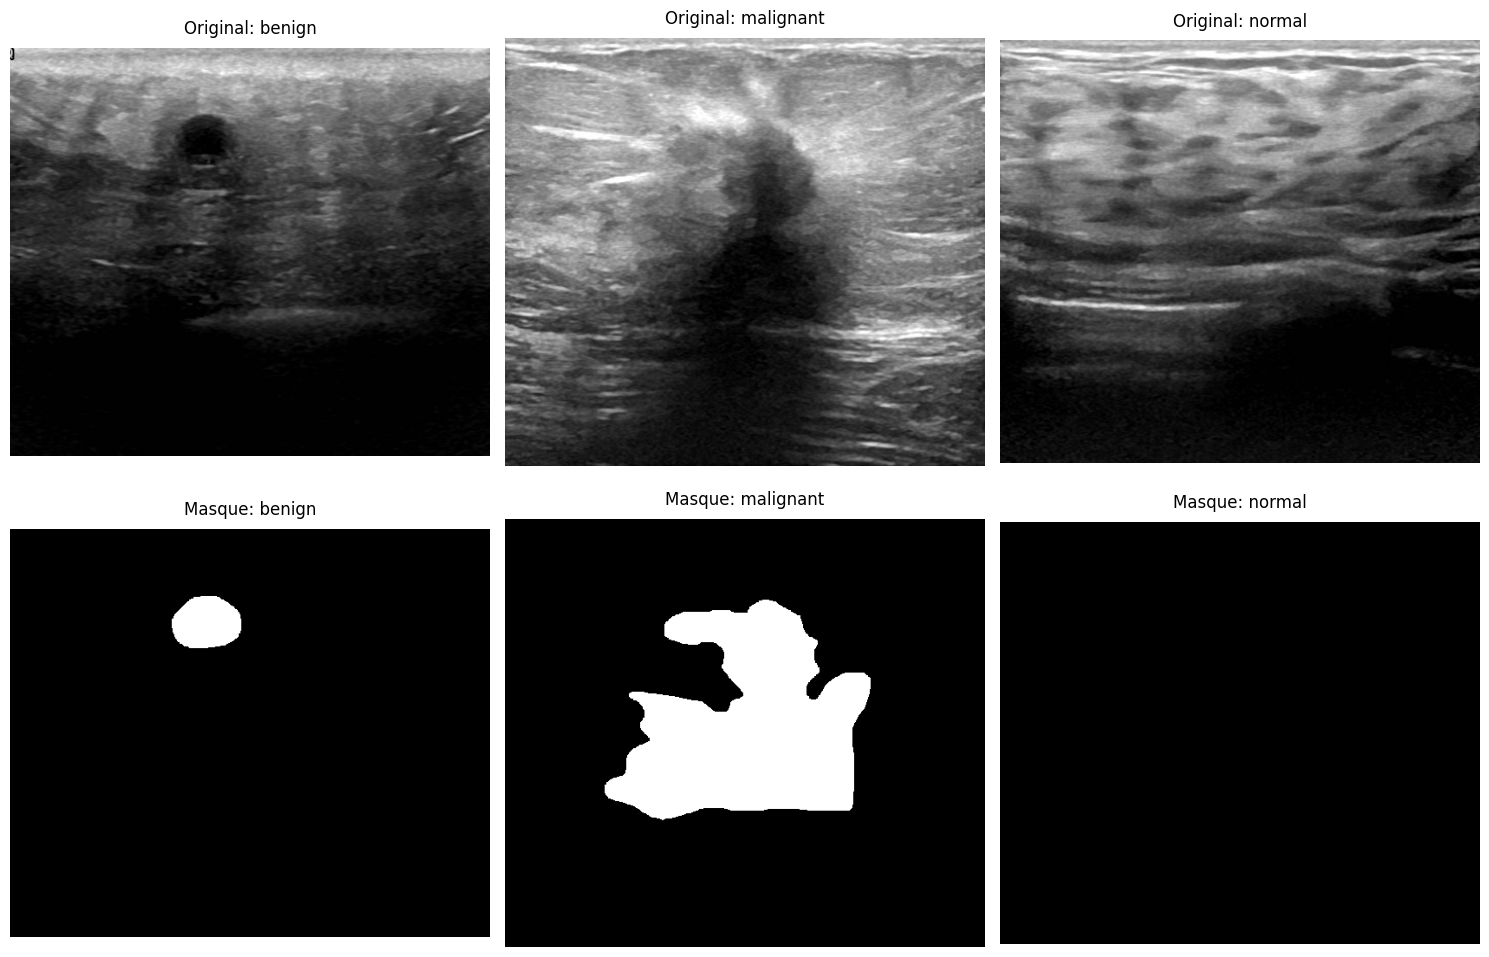

In [8]:
# Affichage d'un échantillon
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA'] # Définir les couleurs

plt.figure(figsize=(15, 8))
plt.suptitle("Échantillon d'une image originale et son masque dans chaque catégorie", 
             size=18, fontweight='bold',
             fontname='monospace', color="#1F1F1F", y=1.02)

# Nous affichons 3 images venant des catégories et leurs masques
num_categories = 3
fig, axes = plt.subplots(2, num_categories, figsize=(15, 10))

# Boucle pour itérer chaque catégorie
for i in range(num_categories):
    # Trouver la première image des données d'entraînement
    for j in range(len(y_train)):
        if y_train[j] == i:
            # Charger l'image et son masque
            original_img = cv2.imread(X_train[j])
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            mask_img = cv2.imread(masked_train[j], cv2.IMREAD_GRAYSCALE)
            
            # Afficher l'image original au premier rang
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f"Original: {categories[i]}", pad=10)
            axes[0, i].axis('off')
            
            # Afficher le masque au second rang
            axes[1, i].imshow(mask_img, cmap='gray')
            axes[1, i].set_title(f"Masque: {categories[i]}", pad=10)
            axes[1, i].axis('off')
            break

plt.tight_layout()

In [9]:
# Quantifier la distribution des régions atteintes de tumeurs (en utilisant les pixels blancs des masques)
mask_pixel_counts = []
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_pixel_counts.append(np.sum(mask > 0))  # Compter les pixels blancs

# Ajouter au DataFrame
df = pd.DataFrame({
    'Catégorie': [categories[l] for l in labels],
    'mask_pixels': mask_pixel_counts
})

# Group by 'Catégorie'
print("\nStatisques sur les images masqués (Région atteint par la tumeur):")
print(df.groupby('Catégorie').describe())


Statisques sur les images masqués (Région atteint par la tumeur):
          mask_pixels                                                        \
                count          mean           std    min       25%      50%   
Catégorie                                                                     
benign          437.0  20734.208238  28769.735793  804.0   4425.00  10263.0   
malignant       210.0  43376.852381  33076.910545  569.0  18006.25  34433.0   
normal          133.0      0.000000      0.000000    0.0      0.00      0.0   

                               
                75%       max  
Catégorie                      
benign     25108.00  209121.0  
malignant  57937.25  167411.0  
normal         0.00       0.0  


# Transformation des données
Création d'une classe pour transformer les données

In [12]:
# ===================================================================
# Classe d'assistance pour transformer les données --> ImageTransform
# ===================================================================
class ImageTransform:
    def __init__(self, image_transform, masked_transform):
        self.image_transform = image_transform
        self.masked_transform = masked_transform

    # Transformer les images et masques (en évitant l'utilisation de if-statements)
    def __call__(self, image, mask):
        return self.image_transform(image), self.masked_transform(mask)


# Transformation des images originales
image_training_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.RandomCrop(224), # Augmenter l'image avec random crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Statistiques de ImageNet
])

# Transformation des images de validation ***À MODIFIER (C'EST LA MÊME QUE image_training_transform)
image_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) 
])

# Transformation des images masqués (aucune normalisation)
masked_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Classe pour la base de données

In [16]:
# ==================================================================================
# Classe pour gérer la base de données d'images échographiques --> UltrasoundDataset
# ==================================================================================
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, masked_paths, labels, transform = None):
        self.image_paths = image_paths
        self.masked_paths = masked_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = cv2.cvtColor(cv2.imread(self.image_paths[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masked_paths[index], cv2.IMREAD_GRAYSCALE)
        label = self.labels[index]
        
        if self.transform:
            image, mask = self.transform(image, mask)

        # Calculer la superficie de la tumeur
        region_tumeur = torch.tensor([tensor.sum(mask > 0).item() / (224*224)])

        return {
            'image': image,
            'masque': mask,
            'Superficie de la tumeur' : region_tumeur,
            'Catégorie' : torch.tensor(label, dtype = torch.long)
        }
        
# Données d'entraînement
training_dataset = UltrasoundDataset(
    X_train, 
    masked_train, 
    y_train, 
    transform = 
        ImageTransform(
            image_training_transform, 
            masked_transform
        ))

# Données de validation
val_dataset = UltrasoundDataset(
    X_test, 
    masked_test, 
    y_test,
    transform = 
        ImageTransform(
            image_val_transform, 
            masked_transform
        ))

# Création du modèle de machine learning

In [ ]:
# ================================================================
# Classe de l'architecture du modèle CNN --> BreastUltrasoundModel
# ================================================================
class BreastUltrasoundModel(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()
        
        # Images originales
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        
        # Images masquées
        self.mask_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Région appartenant à la tumeur
        self.area_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )
        
        # Classifier combinés
        self.classifier = nn.Sequential(
            nn.Linear(num_features + 64*56*56 + 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        pass

    def loss(self, outputs, targets):
        pass


# Setup et boucle d'entraînement du modèle